# Классификация изображений

 Kaggle: Вячеслав_Самаковский_200817238

 Задача: классифицировать персонажей из сериала "Симпсоны".

 Решение: дообучение Resnet50 с предварительной аугументацией.

 Public Score на Kaggle: 0.99362

 Задача подготовленна в рамках домашнего задания по [DLS](https://stepik.org/course/196127/syllabus)

 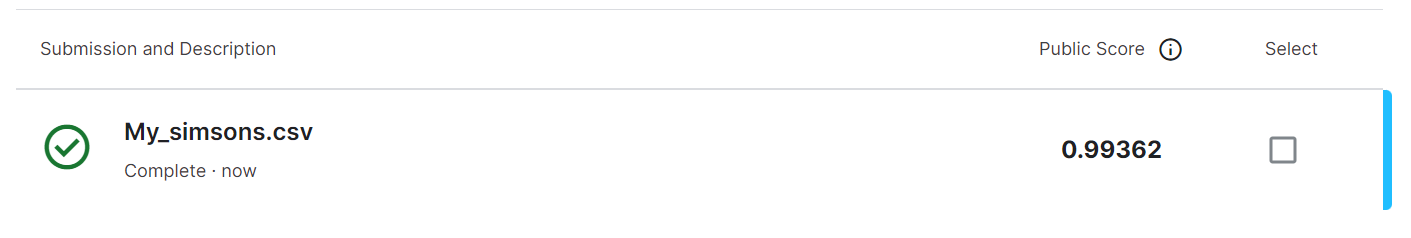

### Установка зависимостей

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

9.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Apr 14 16:46:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В тестовых данных будет 990 картнок, для которых предстоит предсказать класс.

In [ ]:
import pickle
import numpy as np
import pandas as pd
from skimage import io
import math
import random

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline
import seaborn as sns

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже исспользуется враппер над датасетом для удобной работы.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

Разделим тренировочные данные на тренировочную и валидационную часть

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

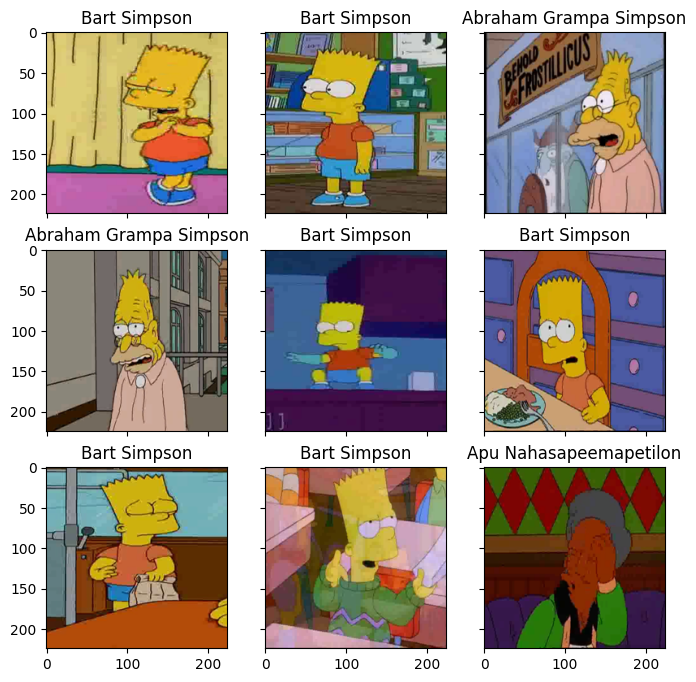

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Аугументация

Посмотрим на распределение классов в обучающем датасете

In [ ]:
def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count')

In [ ]:
data = get_count(train_val_labels)

In [ ]:
def show_data(data, min_level=True, max_level=True):
    plt.figure(figsize=(15, 9))
    sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)
    if max_level:
        plt.axhline(y=1500)
    if min_level:
        plt.axhline(y=100, color='red')
    plt.show()

<ipython-input-23-2cc3ef361042>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)


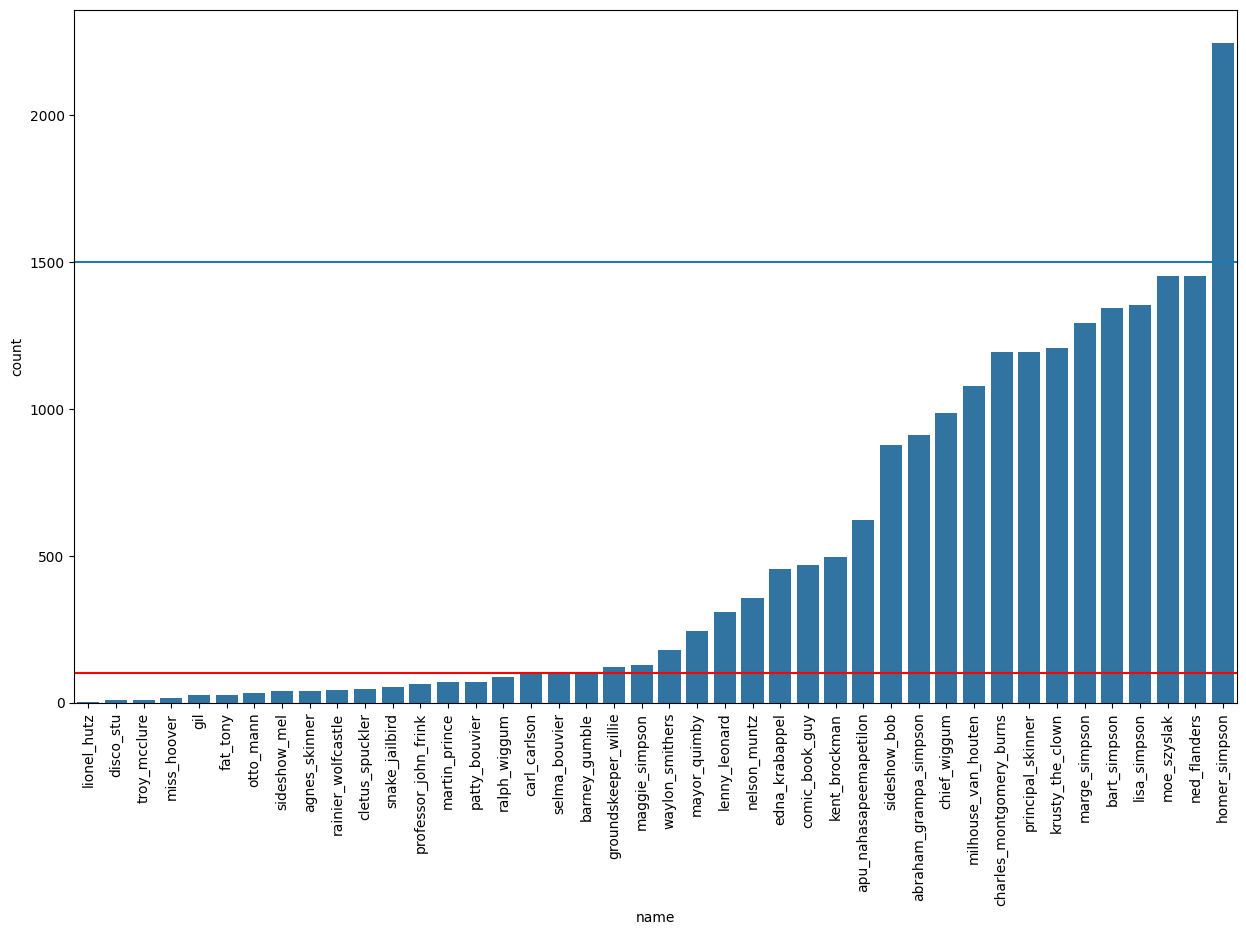

In [ ]:
show_data(data)

Как мы видим, данные сильно несбалансированы.

Мы также рекомендуем вручную добавлять изображения для классов, содержащих менее 100 изображений, поскольку расширение такого небольшого количества изображений только путем увеличения может не дать желаемого результата.

Допустим, мы хотели бы иметь не менее 1500 изображений в каждом классе.

In [ ]:
data['to_add'] = data['count'].apply(lambda x: 1500 - x if x < 1500 else 0)

Столбец «one_iteration» покажет нам, сколько новых изображений мы должны сделать из одного исходного изображения.

In [ ]:
data['one_iteration'] = data.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)
data

,count,to_add,one_iteration
name,,,
lionel_hutz,3,1497,499
disco_stu,8,1492,187
troy_mcclure,8,1492,187
miss_hoover,17,1483,88
gil,27,1473,55
fat_tony,27,1473,55
otto_mann,32,1468,46
sideshow_mel,40,1460,37
agnes_skinner,42,1458,35


Применим случайным образом одно из следующих трёх преобразований:
- `RandomCrop` (`Resize` и `CenterCrop` используются для превращения изображения в квадратное)
- `RandomRotation`
- `RandomHorizontalFlip`

In [ ]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1)
}

In [ ]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

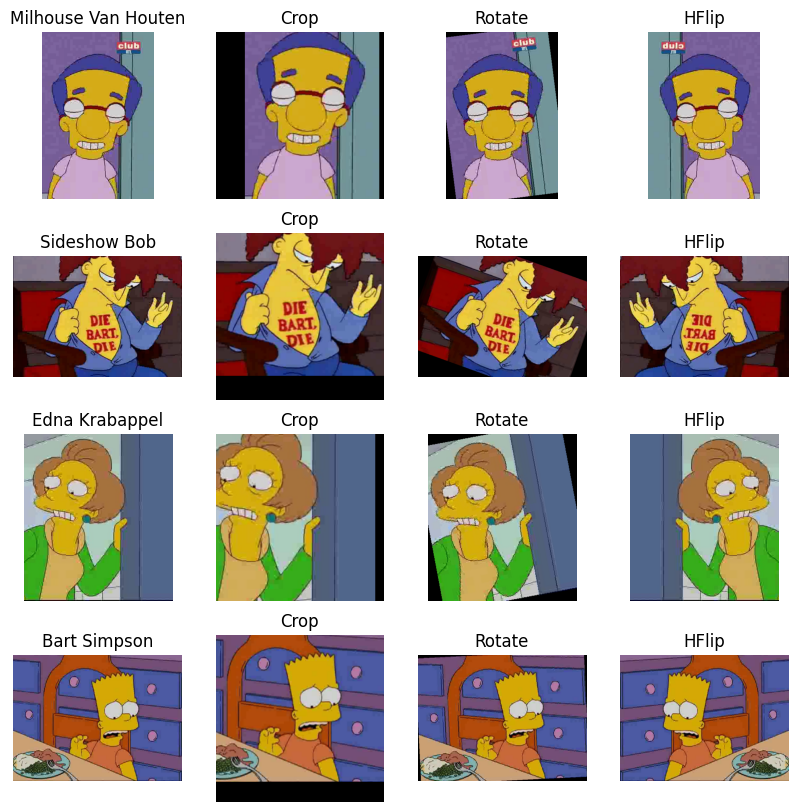

In [ ]:
n_examples = 4

fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1),figsize=(10, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_val_files)))
    img_orig = load_image(train_val_files[random_character])
    img_label = train_val_files[random_character].parent.name

    img_label = " ".join(map(lambda x: x.capitalize(),\
                img_label.split('_')))
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')

    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

Запустим цикл для всех изображений в обучающем датасете.

In [ ]:
for image_path in tqdm(train_val_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = load_image(image_path)
    if data.loc[character]['to_add'] <= 0:
        continue

    if data.loc[character]['one_iteration'] > data.loc[character]['to_add']:
        iter_size = data.loc[character]['to_add']
    else:
        iter_size = data.loc[character]['one_iteration']
    data.loc[character]['to_add'] -= iter_size

    for i in range(iter_size):
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

  0%|          | 0/20933 [00:00<?, ?it/s]<ipython-input-30-09fb41d97d43>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[character]['to_add'] -= iter_size
100%|██████████| 20933/20933 [02:28<00:00, 141.24it/s]


Давайте посмотрим, как теперь выглядят наши данные.

In [ ]:
aug_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
aug_labels = [path.parent.name for path in aug_files]
aug_data = get_count(aug_labels)

<ipython-input-23-2cc3ef361042>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)


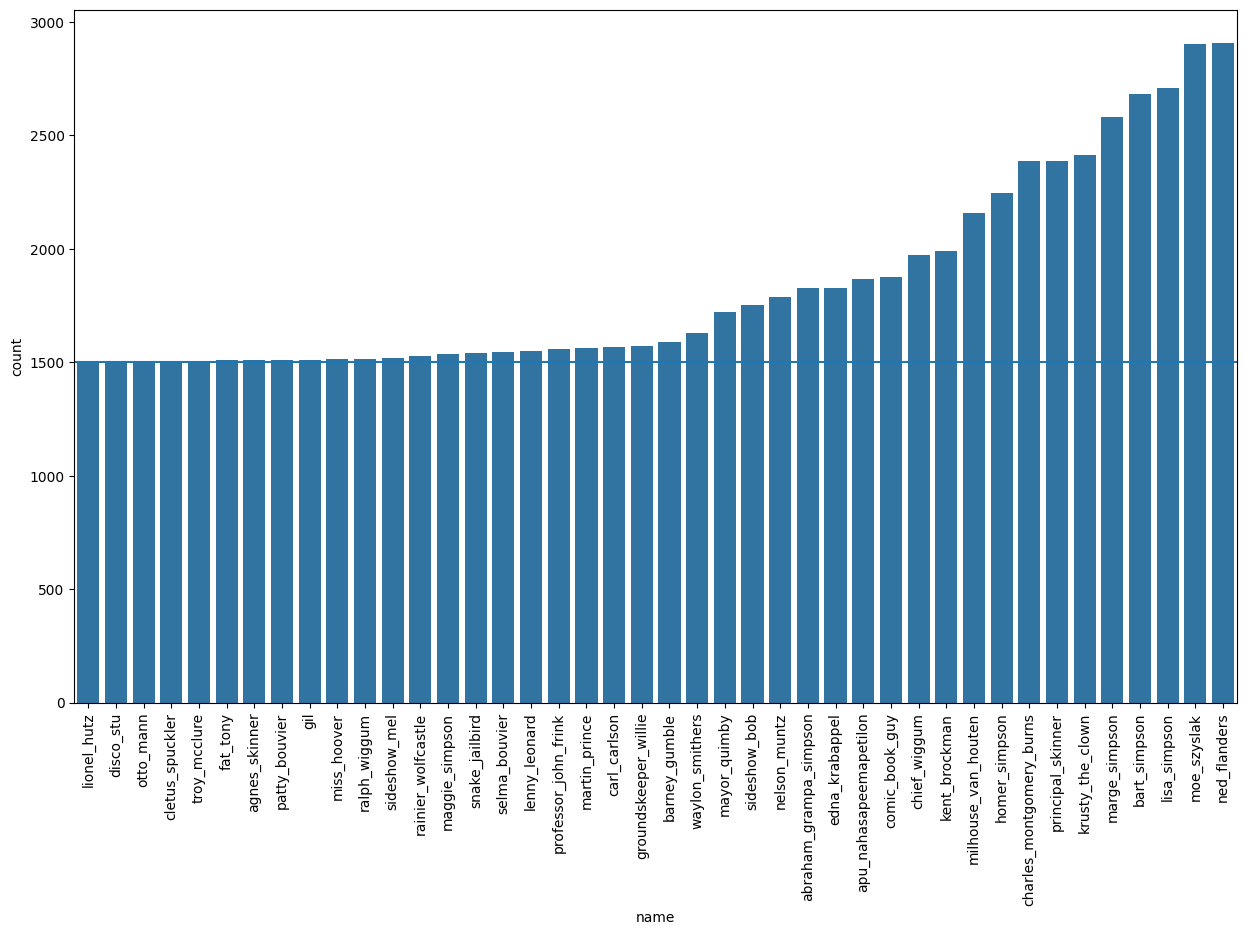

In [ ]:
show_data(aug_data, min_level=False)

### Архитектура нейросети

В качестве нейросети выберем одну из самых популярных и эффективных нейросетей для классификации изображений ResNet50

Определим количество уникальных классов в обучающем и валидационном наборах данных

In [ ]:
print("number to classify :", len(np.unique(train_val_labels)))

number to classify : 42


Создадим экземпляр предобученной модели resnet50

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50

model = resnet50(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Изменим выходной слой для обучения на нашем датасете

In [ ]:
# num_features - размерность вектора признаков, поступающего на вход FC-слою
num_features = 2048
# адаптация модели для текущей задачи классификации с 42 классами
model.fc = nn.Linear(num_features, 42)

In [ ]:
# перенос моделм на устройство, указанное в переменной DEVICE
resnet_model = model.to(DEVICE)

Функция одной эпохи обучения модели

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train(True)
    # накопление общей потери на текущей эпохе
    running_loss = 0.0
    # накопление общего количества правильных предсказаний
    running_corrects = 0
    # накопление общего количества обработанных данных
    processed_data = 0

    # итерация по данным обучающего набора
    for inputs, labels in train_loader:
        # перенос входных данных на устройство
        inputs = inputs.to(DEVICE)
        # перенос меток на устройство
        labels = labels.to(DEVICE)
        # обнуление градиентов
        optimizer.zero_grad()

        # получение предсказаний от модели
        outputs = model(inputs)
        # вычисление потерь
        loss = criterion(outputs, labels)
        # обратное распространение ошибки
        loss.backward()
        # обновление весов модели на основе градиентов
        optimizer.step()
        # получение индексов предсказанных классов
        preds = torch.argmax(outputs, 1)
        # обновление общей потери
        running_loss += loss.item() * inputs.size(0)
        # обновление общего числа правильных предсказаний
        running_corrects += torch.sum(preds == labels.data)
        # обновление общего числа обработанных данных
        processed_data += inputs.size(0)

    # вычисление среднего лосса
    train_loss = running_loss / processed_data
    # вычисление точности
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

Функция оценки модели на валидационном наборе данных

In [ ]:
def eval_epoch(model, val_loader, criterion):
    # установка модели в режим оценки
    model.eval()
    # накопление общего лосса на валидационном наборе
    running_loss = 0.0
    # накопление общего количества правильных предсказаний
    running_corrects = 0
    # накопление общего количества обработанных данных
    processed_size = 0

    # итерация по данным валидационного набора
    for inputs, labels in val_loader:
        # перенос входных данных на устройство
        inputs = inputs.to(DEVICE)
        # перенос меток на устройство
        labels = labels.to(DEVICE)

        # оценка без градиентов
        with torch.set_grad_enabled(False):
            # получение предсказаний от модели
            outputs = model(inputs)
            # вычисление потерь
            loss = criterion(outputs, labels)
            # получение индексов предсказанных классов
            preds = torch.argmax(outputs, 1)

        # обновление общей потери
        running_loss += loss.item() * inputs.size(0)
        # обновление общего числа правильных предсказаний
        running_corrects += torch.sum(preds == labels.data)
        # обновление общего числа обработанных данных
        processed_size += inputs.size(0)

    # вычисление среднего лосса
    val_loss = running_loss / processed_size
    # вычисление точности
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

Функция обучения модели на обучающем наборе и оценки ее производительности на валидационном наборе

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    # создание DataLoader для обучающего и валидационного наборов данных соответственно
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # инициализация истории обучения
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    # использование tqdm для создания прогресс-бара по эпохам
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # инициализация оптимизатора Adam для обновления весов модели
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        # инициализация функции потерь (кросс-энтропия)
        criterion = nn.CrossEntropyLoss()

        # итерация по эпохам
        for epoch in range(epochs):
            #  обучение модели на обучающем наборе и получение потерь и точности на обучении
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            # оценка модели на валидационном наборе и получение потерь и точности на валидации
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            # добавление результатов в историю
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            # вывод статистики обучения и валидации для текущей эпохи
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

Функция для получения предсказаний модели на тестовом наборе данных

In [ ]:
def predict(model, test_loader):
    # включение контекста для выполнения операций без вычисления градиентов
    # это увеличивает производительность и экономит память при предсказаниях
    with torch.no_grad():
        logits = []

        # итерация по тестовому набору данных
        for inputs in test_loader:
            # перенос входных данных на устройство
            inputs = inputs.to(DEVICE)
            # установка модели в режим оценки
            model.eval()
            # Получение предсказаний от модели и перенос их на CPU.
            # cpu() используется, чтобы преобразовать тензоры на CPU и обеспечить совместимость с numpy
            outputs = model(inputs).cpu()
            # добавление предсказаний в список logits
            logits.append(outputs)

    # соединение предсказаний и преобразование их в вероятности с использованием softmax
    # результат преобразуется в массив numpy
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    # возвращаются предсказанные вероятности для тестового набора данных
    return probs

### Обучение нейросети

Обучим нейросеть. К сожалению, возможностей колаба не достаточно для обучения большего количества эпох

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(aug_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=resnet_model, epochs=5, batch_size=64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.22317489772085053


epoch:  20%|██        | 1/5 [19:28<1:17:55, 1168.76s/it]


Epoch 001 train_loss: 0.2232     val_loss 0.0510 train_acc 0.9550 val_acc 0.9883
loss 0.02939448460781772


epoch:  40%|████      | 2/5 [38:56<58:25, 1168.36s/it]


Epoch 002 train_loss: 0.0294     val_loss 0.0203 train_acc 0.9931 val_acc 0.9939
loss 0.022140024983636382


epoch:  60%|██████    | 3/5 [58:23<38:55, 1167.51s/it]


Epoch 003 train_loss: 0.0221     val_loss 0.0171 train_acc 0.9944 val_acc 0.9958
loss 0.0188453768124872


epoch:  80%|████████  | 4/5 [1:17:50<19:27, 1167.45s/it]


Epoch 004 train_loss: 0.0188     val_loss 0.0164 train_acc 0.9948 val_acc 0.9956
loss 0.01639208135987456


epoch: 100%|██████████| 5/5 [1:37:24<00:00, 1168.95s/it]


Epoch 005 train_loss: 0.0164     val_loss 0.0059 train_acc 0.9955 val_acc 0.9979


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

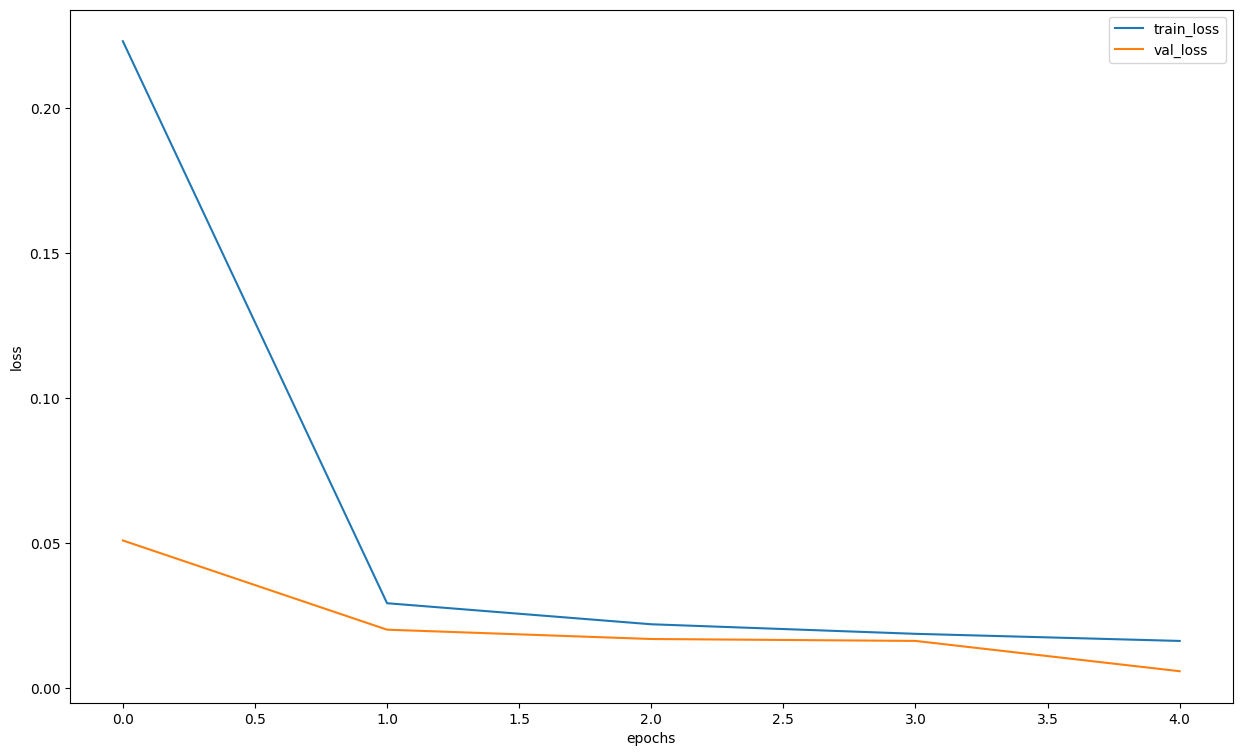

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Как мы можем видеть, и на тренировочных и на валидационных данных loss стремиться к нулю даже на 5ти эпохах

### Предсказание

Функция предсказания модели для одного случайного элемента из валидационного набора данных

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    # переносим входные данные на устройство
    with torch.no_grad():
        inputs = inputs.to(device)
        # устанавливаем модель в режим оценки
        model.eval()
        # получаем логиты (непосредственный вывод модели перед применением softmax)
        logit = model(inputs).cpu()
        # применяем softmax для получения вероятностей и преобразуем в numpy-массив
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
# выбор случайного числа для выбора элемента из валидационного набора данных
random_characters = int(np.random.uniform(0,1000))
# получение изображения и соответствующей метки из валидационного набора данных
# по случайно выбранному индексу random_characters
ex_img, true_label = val_dataset[random_characters]
# используется функция predict_one_sample
# чтобы получить предсказания модели (resnet_model) для данного изображения
probs_im = predict_one_sample(resnet_model, ex_img.unsqueeze(0))

In [ ]:
# создается список из 20 случайных чисел (индексов) в интервале от 0 до 1000
idxs = list(map(int, np.random.uniform(0,1000, 20)))
# формируется список imgs, содержащий изображения, извлеченные из валидационного набора данных
# по случайным индексам idxs. Каждое изображение при этом расширяется с использованием
# unsqueeze(0).
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
# используется функция predict для получения предсказаний модели (resnet_model)
# для списка изображений imgs
# функция predict вероятностные предсказания для каждого изображения возвращает в виде списка
probs_ims = predict(resnet_model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
# вычисляем индексы классов с наибольшей вероятностью для каждого предсказания в probs_ims
y_pred = np.argmax(probs_ims,-1)
# получаем факт. метки классов из валидационного набора для случайно выбранных изображений
actual_labels = [val_dataset[id][1] for id in idxs]
# преобразуем предсказанные индексы классов (y_pred) обратно в соответствующие текстовые метки
# классов с использованием объекта label_encoder.classes_
# таким образом, preds_class становится списком текстовых меток, предсказанных моделью

# преобразуем предсказанные индексы классов (y_pred) обратно в соответствующие текстовые метки
# классов с использованием объекта label_encoder.classes_
# таким образом, preds_class становится списком текстовых меток, предсказанных моделью
preds_class = [label_encoder.classes_[i] for i in y_pred]

### Вычисление метрики F1-score

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)

F1-score: 1.0


### Визуализация уверенности модели

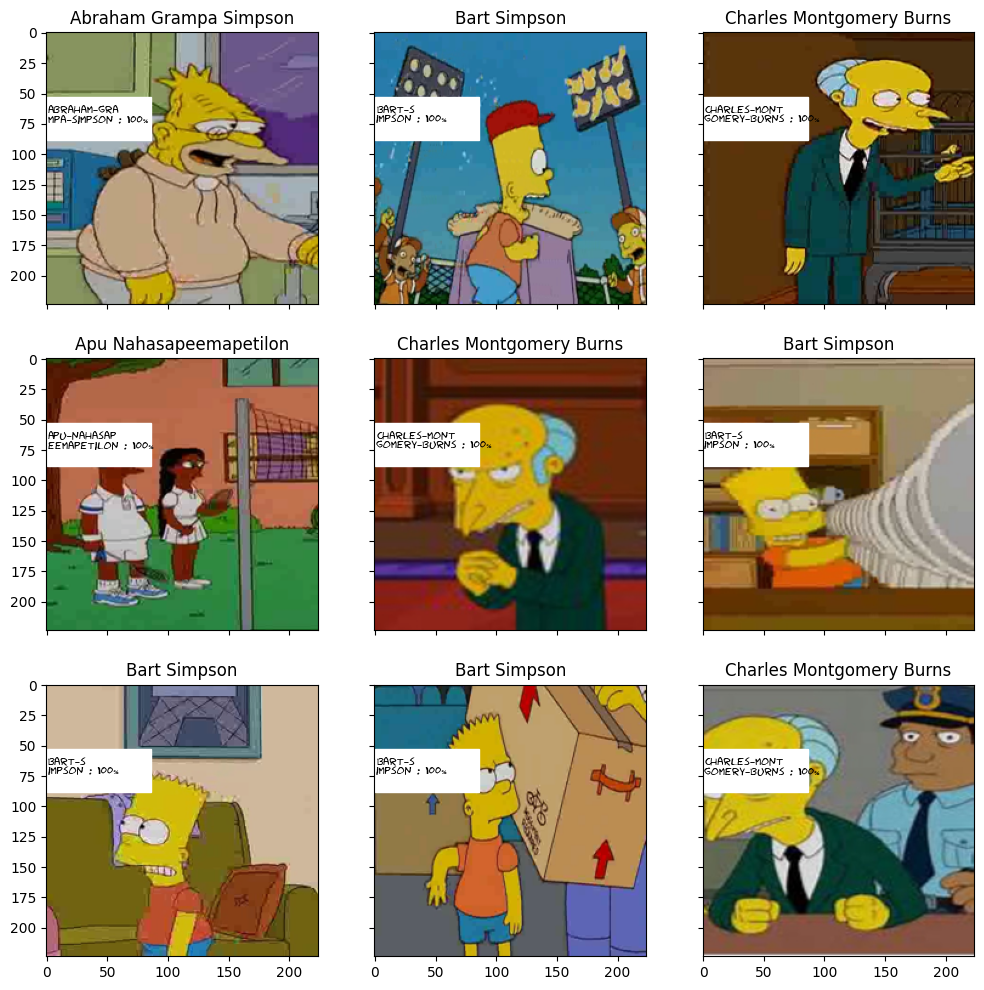

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

# создаем сетку из 3 строк и 3 столбцов графиков с общими осью y и x
# create a grid of 3 rows and 3 columns of graphs with common y and x axes
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
# итерируется по всем осям в сетке
# iterates over all axes in the grid
for fig_x in ax.flatten():
    # выбираем случайный индекс изображения из валидационного набора
    # select a random image index from the validation set
    random_characters = int(np.random.uniform(0,1000))
    # получаем изображение и соответствующую метку из валидационного набора
    # get the image and the corresponding label from the validation set
    im_val, label = val_dataset[random_characters]
    # преобразует текстовую метку в формате "class_name" в более читаемый вид
    # где каждое слово начинается с заглавной буквы
    # converts a text label in the "class_name" format to a more readable form
    # where each word begins with a capital letter
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))


    # отображаем изображение с заголовком на текущей оси графика
    # display an image with a title on the current graph axis
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)
    # добавляем прямоугольник и текст с предсказанными метками и вероятностью на график
    # добавляем прямоугольник и текст с предсказанными метками и вероятностью на график
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    # вычисляем предсказанные вероятности для текущего изображения
    # calculate predicted probabilities for the current image
    prob_pred = predict_one_sample(resnet_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Соответственно, как и на кривых обучения, мы можем видеть, что сеть обучилась и показывает хорошее качество на тестовых данных.

### Submit

Для подтверждения результата, проверим предсказания нашей нейросети в соревновании на кагл. Для этого запишим классы для тестовых изображений в файл

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('My_simsons.csv', index=False)